# Introduction
Once the training is done, visualisation of the output is really helpful for a qualitative inspection. However, one may want to have also some synthetic, reliable measures that quantify the goodness of fit of the model.

In this notebook we will see some quantitative metrics that may be useful to assess model performances for the analysis presented.

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import seaborn as sns
#import plotly.plotly as py
#import plotly.graph_objs as go
#from plotly.offline import iplot, init_notebook_mode
#init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

/home/luca/anaconda3/envs/tensorflow/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:558: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/home/luca/anaconda3/envs/tensorflow/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:531: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis




## General packages  

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model, Model, Sequential
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers import Input, Dropout, Activation, Conv2D, MaxPooling2D, UpSampling2D, Lambda, BatchNormalization
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import callbacks, initializers, layers, models, optimizers
from keras import backend as K

import cv2

Using TensorFlow backend.


## Custom modules 

In [3]:
import sys
code_path = "../code"
sys.path.append(code_path)

from config_script import *
import training
import post_processing
import visualise_results

# Analysis/Modeling

## Training metrics 

As first thing we can have a look at the loss and the metrics when applying the model to new, unseen images.

In [4]:
test_generator, v, seed = training.setup_pipeline(custom_augmentation=None, training_img_path=SAMPLE_IMG_PATH,
                                    training_masks_path=SAMPLE_MASKS_PATH, valid_img_path=None,
                                    valid_masks_path=None, IMG_HEIGHT=1200,IMG_WIDTH=1600,
                                    val_percentage=0.3, color='rgb', BATCH_SIZE=3, VALID_BATCH_SIZE=3, seed=None)

Found 17 images belonging to 1 classes.
Found 17 images belonging to 1 classes.


In [5]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.2, 0.8, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# dice loss


def dice_coef(y_true, y_pred):
    """Generate the 'Dice' coefficient for the provided prediction.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The Dice coefficient between the expected and actual outputs. Values
        closer to 1 are considered 'better'.
    """
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    """Model loss function using the 'Dice' coefficient.
    Args:
        y_true: The expected/desired output mask.
        y_pred: The actual/predicted mask.
    Returns:
        The corresponding loss, related to the dice coefficient between the expected
        and actual outputs. Values closer to 0 are considered 'better'.
    """
    return -dice_coef(y_true, y_pred)

In [6]:
model = load_model(str(MODEL_CHECKPOINTS/ 'UNet_RGB_notebook_AML.h5'),
                   custom_objects={'mean_iou': mean_iou, 'dice_coef': dice_coef})

In [7]:
metrics = model.evaluate_generator(generator=test_generator, steps=9 )

In [8]:
metrics_label = ["Binary Crossentropy:", "Mean Intersection Union:", "Dice Coefficient:"]
for idx, m in enumerate(metrics):
    print(metrics_label[idx], round(m, 4))

Binary Crossentropy: 0.0403
Mean Intersection Union: 0.4393
Dice Coefficient: 0.0172


## Counting score 

Now we can try to extract better indicators of model's performances with respect to the task of interest: counting neuronal cells.

In [9]:
%%time

threshold = 0.018

# create dataframe for storing performance measures
test_metrics = pd.DataFrame(
    columns=["TP", "FP", "FN", "Target_count", "Predicted_count"])

# loop on test images
for img_path in SAMPLE_IMG_PATH.iterdir():
    img_name = img_path.name

    mask_path = SAMPLE_MASKS_PATH / img_name

    # read original image
    img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # compute predicted mask and extract predicted objects and counts
    pred_mask_rgb = post_processing.make_prediction(img_path, threshold, model)

    # read mask and extract target objects and counts
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

    post_processing.compute_metrics(pred_mask_rgb, mask, test_metrics, img_path.name)

# compute performance measures for the current threshold
summary_metrics = post_processing.F1Score(test_metrics)

CPU times: user 27.5 s, sys: 4.49 s, total: 31.9 s
Wall time: 30.6 s


### Mean Absolute Error 

A straightforward way to assess the performances in the counting task is to compare predicted and true objects by means of the mean absoulte error (MAE) and the mean percentage error (MPE):

$$\text{MAE} = \lvert predicted -true \rvert \hskip 3cm  \text{MPE} = \frac{predicted - true }{ true}$$

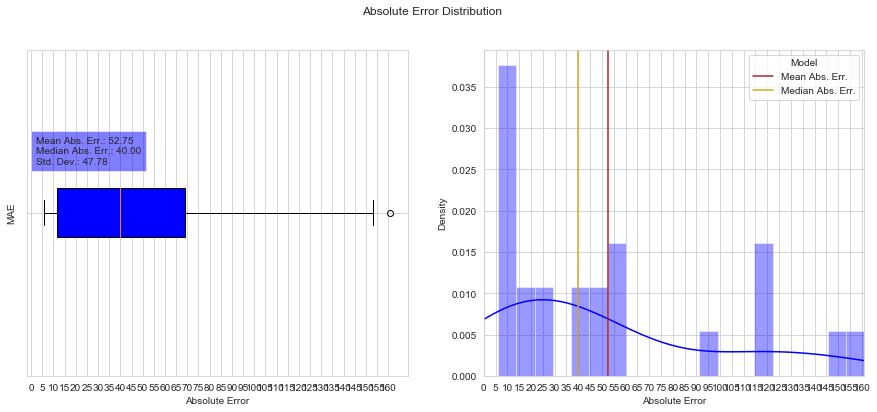

In [10]:
visualise_results.plot_MAE(test_metrics)

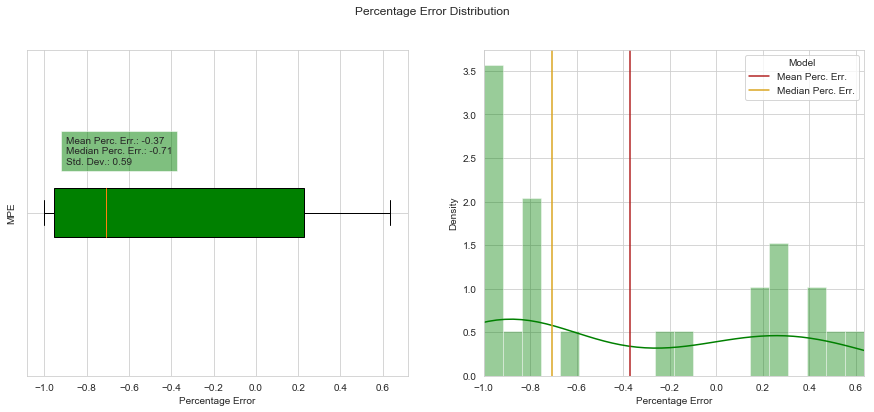

In [11]:
visualise_results.plot_MPE(test_metrics)

As we can see from the plots above, both indicator have a skewed distributions with long right tails. The central tendency of both MAE and MPE is very far from 0, suggesting a great distance between predicted and true counts. In particular, given the negative values for MPE, we can say that on average the model underestimates the number of objects present in the images.

## Classification metrics 

Other insights can be drawn looking at classification metrics.

Indeed, altough the task at hand is not originally related to classifying correcly the objects, it is still interesting to explore the degree of accordance between cells detected from the model and the ones tagged by human annotators.

For this reason, we will investigate some common classification metrics as F1 score, accuracy, precision and recall:

$$\begin{eqnarray*}
\text{F1 score} &=& \frac{2 \cdot \text{precision} \cdot \text{recall}}{ \text{precision} + \text{recall} }
\\
 \text{accuracy} &=& \frac{ \text{TP} }{ \text{TP} + \text{FP} + \text{FN} }
\\
 \text{precision} &=& \frac{ \text{TP} }{ \text{TP} + \text{TN} }
\\
 \text{recall} &=& \frac{ \text{TP} }{ \text{TP} + \text{FN} }
\end{eqnarray*}$$

where TP = true positives, FP = false positives and FN = false negatives.

In [12]:
metrics_label = ["F1 score:", "Mean Absolute Error:", "Mean Percentage Error:", 
                 "Accuracy", "Precision:", "Recall:"]
for idx, m in enumerate(summary_metrics):
    print(metrics_label[idx], round(m, 4))

F1 score: 0.362
Mean Absolute Error: 52.75
Mean Percentage Error: -0.3706
Accuracy 0.221
Precision: 0.6032
Recall: 0.2586


Again, the metrics indicate overall poor performances also in the classification task. Nonetheless, the precision is around 60%.